In [40]:
import pickle
from datetime import datetime as dt
import os
import re
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

import data_exploration_tools as EDA
from pipeline_objects import MyProbBuilder

Import the most recent data.

In [41]:
day = dt.today().day
month = dt.today().month
year = dt.today().year

dt_str = os.path.join('.', 'reddit_data_{}-{}-{}'.format(month, day, year) )

df = pd.read_pickle(dt_str)

Clean up the data by building a few new simple features, dropping useless columns (including those which have a cardinality of 1), and dropping all instances of Subreddits which aren't useful to the endeavor (e.g. '\r\blog' which only has two posts, both of which are gilded, and is a subreddit entirely devoted to Moderator posts about the Reddit platform itself).

In [42]:
new_feats = ['gilded', 'weekday', 'post_hour', 'scrape_time']
new_cols = EDA.handle_unique_columns(df)

for idx, feature in enumerate(new_feats):
    df[feature] = new_cols[idx]

df.drop(columns = EDA.get_all_useless_cols(df), inplace = True)
df = EDA.remove_useless_subreddits(df, ['blog']).reset_index(drop=True)

## Build a simple model using heuristics

Rather than trying to throw some Machine Learning algorithms at the problem right off the bat, I will try to build a very simple probabilistic model based on a few of the features. This will give a baseline, a more complicated model must show significant improvement over this one if it is to be considered succesfull. 

Three features stand out as having good predictive power:

* *Subreddit*
* *Post Hour*
* *Upvote Rate*

For the discrete, categorical variables *Subreddit* and *Post Hour* I will use the relative frequency of gilded posts in each bin to define a probability-of-gilding to use for predictions. For *Upvote Rate* I will first need to bin before also calculating the relative frequency.

Be iterating over every possible combination of values within these three features the relative frequencies will be computed *without* assuming that the features are independent of one another. The price paid for this is a relatively resource-expensive calculation.

#### Binning

Need a tool for binning across multiple features and computing quantities of interest for each bin. This iterates over every combination, a very brute-force approach that relies on both Pandas and Numpy. A vectorized treatment would be preferable - however as this is likely a one-time-use tool there does not seem to be a strong argument made for spending more time improving efficiency.

In [43]:
label_fsize = 14
title_fsize = 18

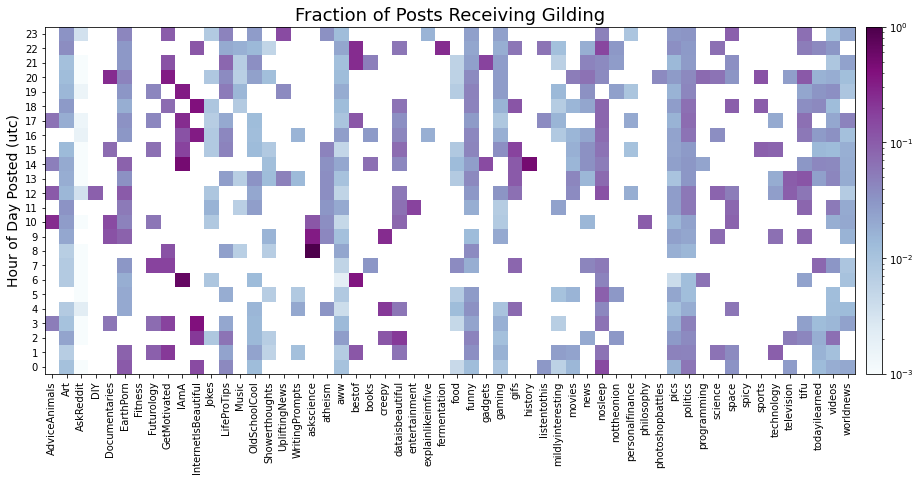

In [44]:
prob_sub_time = MyProbBuilder(['subreddit', 'post_hour'])
prob_sub_time.fit(df, df['gilded'])

subr_time_array = prob_sub_time.fracs_array().transpose()

fig, ax = plt.subplots(1,1, figsize=(15,15))

hmap = ax.imshow(subr_time_array, cmap = 'BuPu', norm=LogNorm(vmin=0.001, vmax = subr_time_array.max()))
ax.set_yticks(range(len(prob_sub_time.feat1_values)))
ax.set_xticks(range(len(prob_sub_time.feat0_values)))
ax.set_xticklabels(prob_sub_time.feat0_values, rotation = 90)
ax.invert_yaxis()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.15)
plt.colorbar(hmap, cax = cax)

ax.set_ylabel('Hour of Day Posted (utc)', fontsize = label_fsize)
ax.set_title('Fraction of Posts Receiving Gilding', fontsize = title_fsize)
plt.show()

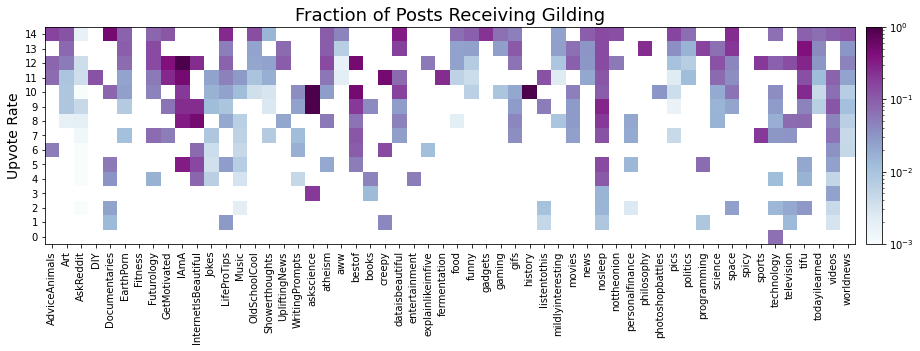

In [45]:
prob_sub_upv = MyProbBuilder(['subreddit',], ['upvote_rate'], num_bins = 15)
prob_sub_upv.fit(df, df['gilded'])

subr_upv_array = prob_sub_upv.fracs_array().transpose()

fig, ax = plt.subplots(1,1, figsize=(15,15))

hmap = ax.imshow(subr_upv_array, cmap = 'BuPu', norm=LogNorm(vmin=0.001, vmax = subr_upv_array.max()))
ax.set_yticks(range(len(prob_sub_upv.feat1_values)))
ax.set_xticks(range(len(prob_sub_upv.feat0_values)))
ax.set_xticklabels(prob_sub_upv.feat0_values, rotation = 90)
ax.invert_yaxis()
ax.set_ylabel('Upvote Rate', fontsize = label_fsize)
ax.set_title('Fraction of Posts Receiving Gilding', fontsize = title_fsize)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.15)
plt.colorbar(hmap, cax = cax)

plt.show()

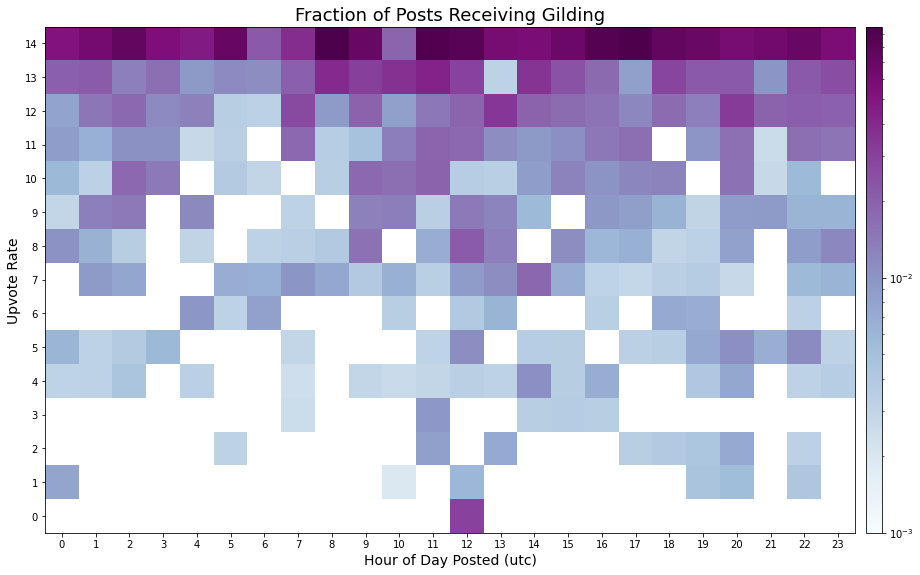

In [39]:
prob_time_upv = MyProbBuilder(['post_hour'], ['upvote_rate'], num_bins = 15)
prob_time_upv.fit(df, df['gilded'])

time_upv_array = prob_time_upv.fracs_array().transpose()

fig, ax = plt.subplots(1,1, figsize=(15,15))

hmap = ax.imshow(time_upv_array, cmap = 'BuPu', norm=LogNorm(vmin=0.001, vmax = time_upv_array.max() ))
ax.set_yticks(range(len(prob_time_upv.feat1_values)))
ax.set_xticks(range(len(prob_time_upv.feat0_values)))
ax.set_xticklabels(prob_time_upv.feat0_values)
ax.invert_yaxis()
ax.set_ylabel('Upvote Rate', fontsize = label_fsize)
ax.set_xlabel('Hour of Day Posted (utc)', fontsize = label_fsize)
ax.set_title('Fraction of Posts Receiving Gilding', fontsize = title_fsize)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.15)
plt.colorbar(hmap, cax = cax)

plt.show()